# Load Data

In [1]:
import pickle
import os
from tqdm import tqdm
import numpy as np

directory = 'data/train'

length_list = []
valence_values=[]

recordings = []

for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.pkl'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            if data['valence'] != 2.333 and len(data['audio_data']) < 91000:
                length_list.append(len(data['audio_data']))
                valence_values.append(data['valence'])
                recordings.append(data['audio_data'])

valence_values = np.array(valence_values)


100%|██████████| 10557/10557 [00:25<00:00, 418.16it/s]


In [2]:
valennce_dist ={}
for i in valence_values:
    if i in valennce_dist:
        valennce_dist[i] += 1
    else:
        valennce_dist[i] = 1


valennce_dist


{1.25: 140,
 3.5: 1173,
 3.25: 1273,
 3.75: 972,
 2.0: 523,
 2.75: 1014,
 2.25: 679,
 3.0: 1045,
 4.25: 606,
 1.0: 114,
 1.5: 227,
 1.75: 407,
 4.75: 151,
 4.0: 784,
 2.5: 890,
 5.0: 28,
 4.5: 365}

In [3]:
# Calculate the maximum length
max_length = max(length_list)

# Adjust the recordings to have the same length
adjusted_recordings = []
for recording in recordings:
    # Repeat the array until it reaches or exceeds the maximum length
    repeated_recording = np.tile(recording, (max_length // len(recording) + 1))[:max_length]
    adjusted_recordings.append(repeated_recording)

valence_values = np.array(valence_values)
len(adjusted_recordings), adjusted_recordings[0].shape



(10391, (90948,))

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


############################################################################################################


############################################################################################################
# Pad the recordings to have the same length
max_length = max(len(array) for array in recordings)  # Find the maximum length

# # Pad each array to have the maximum length
# padded_arrays = np.array([np.pad(array, (0, max_length - len(array)), mode='constant') for array in recordings])


############################################################################################################
# Split the data and labels into training and testing sets
X_train, X_test_help, y_train, y_test_help = train_test_split(adjusted_recordings, valence_values, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test_help, y_test_help, test_size=0.5, random_state=42)



############################################################################################################
# Create a DataLoader for the training set, test set, and validation set

batch_size = 256  # You can adjust the batch size depending on your system's capability

# Convert input data and labels to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Use float32 for labels

# Create a dataset from tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

############################################################################################################
# Repeat the same process for the test set

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



############################################################################################################
# Repeat the same process for the validation set
X_validation_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_validation_tensor = torch.tensor(y_val, dtype=torch.float32)

validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)




C:\Users\20211922\AppData\Local\Temp\ipykernel_20564\108390367.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features


In [5]:
import matplotlib.pyplot as plt

def calculate_label_distribution(labels_tensor):
    label_dist = {}
    for label in labels_tensor:
        label = label.item()  # Convert tensor to int
        if label in label_dist:
            label_dist[label] += 1
        else:
            label_dist[label] = 1
    return label_dist

train_labels = train_loader.dataset.tensors[1]

train_valence_dist = calculate_label_distribution(train_labels)






# Augment Data

In [6]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, RoomSimulator, Aliasing, HighPassFilter, LowPassFilter,ApplyImpulseResponse
import numpy as np
import torch
import sounddevice as sd
import random


def draw_augmentations(text,amount,fs=12000):
    
    augmentGaussian = Compose([
        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=1),
    ])

    augmentPitchShift = Compose([
        PitchShift(min_semitones=-4, max_semitones=4, p=1),
    ])

    # augmentRoomSimulator = Compose([
    #     RoomSimulator(p=1)
    # ])

    augmentAliasing = Compose([
        Aliasing(min_sample_rate=8000, max_sample_rate=30000,p=1)
    ])

    augmentHPF = Compose([
        HighPassFilter(min_cutoff_freq=15, max_cutoff_freq=2400,p=1)
        ])

    augmentedLPF = Compose([
        LowPassFilter(p=1)
    ])


    list_of_augmentations = [ augmentGaussian, augmentPitchShift, augmentAliasing, augmentHPF, augmentedLPF]

    functions = random.sample(list_of_augmentations, amount,)
    for i in functions:
        # print(i.__name__)
        text = i(text, sample_rate=fs)
    # sd.play(text, fs)
    return text


In [7]:

waveforms = train_loader.dataset.tensors[0].numpy().squeeze()  # Convert tensor to NumPy array
labels = train_loader.dataset.tensors[1].numpy().squeeze()  # Convert tensor to NumPy array


# Create a dictionary to hold the data categorized by labels
label_dict = {}

# Iterate through each label and corresponding waveform
for waveform, label in zip(waveforms, labels):
    if label not in label_dict:
        label_dict[label] = []
    label_dict[label].append(waveform)


# for label in label_dict:
#     for k in label_dict[label]:
#         print(k.shape)
        





In [8]:
from tqdm import tqdm
def train_balancer(train_valence_dist):
    train_balanced = {}
    for label in train_valence_dist.keys():
        train_balanced[label] = []
    for label in tqdm(train_valence_dist.keys()):
        if train_valence_dist[label] < 400:
            for recording in range(len(label_dict[label])):
                train_balanced[label].append(label_dict[label][recording])
            for _ in range(400 - len(label_dict[label])):
                choose_func_amount = random.randint(1, 3)
                choose_index = random.randint(0, len(label_dict[label])-1)
                train_balanced[label].append(draw_augmentations(label_dict[label][choose_index],choose_func_amount))
        else:
            indices = random.sample(range(len(label_dict[label])), 400)
            for index in indices:
                train_balanced[label].append(label_dict[label][index])
    return train_balanced


train_balanced = train_balancer(train_valence_dist= train_valence_dist)
print(train_balanced.keys())
        

100%|██████████| 17/17 [00:35<00:00,  2.06s/it]

dict_keys([3.5, 2.5, 3.25, 3.75, 1.75, 1.25, 3.0, 4.5, 4.25, 2.0, 4.0, 1.5, 2.25, 1.0, 2.75, 4.75, 5.0])


In [9]:
# for d in train_balanced:
#     for i in train_balanced[d]:
#         print(i.shape)

In [10]:
def array_to_hashable(arr):
    return hash(arr.tobytes())

for arrays in train_balanced.keys():
    print("Label: ", arrays)
    # Convert each array to a hashable type
    unique_hashes = set(array_to_hashable(arr) for arr in train_balanced[arrays])

    # The number of unique arrays
    num_unique_arrays = len(unique_hashes)
    print("Number of unique arrays for : ", num_unique_arrays)

    

Label:  3.5
Number of unique arrays for :  400
Label:  2.5
Number of unique arrays for :  400
Label:  3.25
Number of unique arrays for :  400
Label:  3.75
Number of unique arrays for :  400
Label:  1.75
Number of unique arrays for :  400
Label:  1.25
Number of unique arrays for :  400
Label:  3.0
Number of unique arrays for :  400
Label:  4.5
Number of unique arrays for :  400
Label:  4.25
Number of unique arrays for :  400
Label:  2.0
Number of unique arrays for :  400
Label:  4.0
Number of unique arrays for :  400
Label:  1.5
Number of unique arrays for :  400
Label:  2.25
Number of unique arrays for :  400
Label:  1.0
Number of unique arrays for :  400
Label:  2.75
Number of unique arrays for :  400
Label:  4.75
Number of unique arrays for :  400
Label:  5.0
Number of unique arrays for :  400


In [11]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np



test_dict = train_balanced

# Flatten the dictionary into lists of samples and labels
X_train = []
y_train = []
for label, arrays in tqdm(test_dict.items()):
    for array in arrays:
        X_train.append(array)
        y_train.append(label)  # Adjust how labels are encoded as needed


# Convert lists to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Adjust the type depending on how you encode labels

# Create a dataset from tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Define the batch size
batch_size = 256  # Adjust batch size based on your system capability

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(train_loader.dataset.tensors[0].shape)

100%|██████████| 17/17 [00:00<?, ?it/s]


torch.Size([6800, 1, 90948])


# **MODEL**

In [12]:
def round_to_nearest_quarter(number):
    # Assuming 'number' could be a numpy array with a single value
    if isinstance(number, np.ndarray) and number.size == 1:
        number = number.item()  # Convert single-item array to scalar
    
    # Ensure the number is within the 1 to 5 range before processing
    number = np.clip(number, 1, 5)
    # Scale number to shift quarters to whole numbers, round, and rescale
    rounded_number = np.round(number * 4) / 4
    # Clip again to ensure no out-of-range values after rounding
    rounded_number = np.clip(rounded_number, 1, 5)
    return str(rounded_number)

In [13]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torchaudio.transforms as transforms


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()



        # Set random seed for reproducibility
        torch.manual_seed(42)


        self.mfcc_transform = transforms.MFCC(
            sample_rate=44100,      ## 44.1 kHz
            n_mfcc=24              ## Created channels
        )

        self.layers = nn.ModuleList()
        
        self.layers.append(nn.BatchNorm1d(24))
        conv1 = nn.Conv1d(in_channels=24, out_channels=48, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv1.weight, nonlinearity='relu')
        self.layers.append(conv1)
        self.layers.append(nn.BatchNorm1d(48))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3))
        self.layers.append(nn.Dropout(0.25))

        conv2 = nn.Conv1d(in_channels=48, out_channels=48, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv2.weight, nonlinearity='relu')
        self.layers.append(conv2)
        self.layers.append(nn.BatchNorm1d(48))
        self.layers.append(nn.ReLU())


        conv3 = nn.Conv1d(in_channels=48, out_channels=12, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv3.weight, nonlinearity='relu')
        self.layers.append(conv3)
        self.layers.append(nn.BatchNorm1d(12))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3))
        self.layers.append(nn.Dropout(0.25))


        self.layers.append(nn.Flatten())

        linear1= nn.Linear(564,256)
        nn.init.kaiming_normal_(linear1.weight, nonlinearity='relu')
        self.layers.append(linear1)
        self.layers.append(nn.ReLU())
        
        linear2 = nn.Linear(256, 1)
        nn.init.kaiming_normal_(linear2.weight, nonlinearity='relu')
        self.layers.append(linear2)


    
    def forward(self, x):
        x = self.mfcc_transform(x)
        x = x.squeeze(1)
        for layer in self.layers:
            x = layer(x)
            #print(x.shape)
        return x.view(-1)


### CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Training Cycle

def train_model(MLP_model, optimizer, num_epochs):
        criterion = nn.MSELoss()
        #criterion = nn.L1Loss()
        # Training loop
        for epoch in tqdm(range(num_epochs)):
            total_loss = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = MLP_model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute the loss
                loss.backward()  # Backward pass

                optimizer.step()

                # Store the loss. loss.item() gets the value in a tensor. This only works for scalars.
                total_loss += loss.item()
        
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')
            if epoch > 1:
                print(evaluate_model(MLP_model, validation_loader,conf=False))
            print('--------------------------------------------------')
        print(evaluate_model(MLP_model, train_loader,conf=True))


def evaluate_model(MLP_model, test_loader,conf=False):
    with torch.no_grad():
        ### Calculate MSE 
        predictions = []
        actuals = []
        actuals_for_cm = []
        rounded_predictions = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = MLP_model(inputs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
            actuals_for_cm.extend([str(label) for label in labels.cpu().numpy()])
            rounded_predictions.extend([str(round_to_nearest_quarter(output)) for output in outputs.cpu().numpy()])

        predictions = np.array(predictions)
        actuals = np.array(actuals)
        mse = np.mean((predictions - actuals) ** 2)
        mae = np.mean(np.abs(predictions - actuals))
        print(f'Mean Squared Error: {mse:.4f} and Mean Absolute Error: {mae:.4f}')

        # for i in range(10):
        #     print(f"Predictions: {predictions[i]}")
        #     print(f"Actuals: {actuals[i]}")
        #     print(f"Rounded Predictions: {rounded_predictions[i]}")
        
        ##################
        # Confusion Matrix
        ##################
        if conf:
            ### Confusion Matrix
            cm = confusion_matrix(actuals_for_cm, rounded_predictions)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(actuals), yticklabels=np.unique(actuals))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()
            ### Accuracy
            accuracy = np.trace(cm) / np.sum(cm)
            print(f'Accuracy: {accuracy:.4f}')
            
        

        


c:\Users\20211922\Documents\DeepL\DL_ASSIGNMENT\.venv\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
  2%|▏         | 1/50 [00:07<06:22,  7.80s/it]

Epoch [1/50], Loss: 2.5590
--------------------------------------------------


  4%|▍         | 2/50 [00:10<03:54,  4.88s/it]

Epoch [2/50], Loss: 1.3975
--------------------------------------------------
Epoch [3/50], Loss: 1.1801


  6%|▌         | 3/50 [00:14<03:20,  4.27s/it]

Mean Squared Error: 0.7529 and Mean Absolute Error: 0.6948
None
--------------------------------------------------
Epoch [4/50], Loss: 1.0707


  8%|▊         | 4/50 [00:17<03:03,  3.99s/it]

Mean Squared Error: 0.7330 and Mean Absolute Error: 0.6907
None
--------------------------------------------------
Epoch [5/50], Loss: 0.9845


 10%|█         | 5/50 [00:21<02:52,  3.83s/it]

Mean Squared Error: 0.6951 and Mean Absolute Error: 0.6800
None
--------------------------------------------------
Epoch [6/50], Loss: 0.9353


 12%|█▏        | 6/50 [00:24<02:43,  3.71s/it]

Mean Squared Error: 0.6732 and Mean Absolute Error: 0.6609
None
--------------------------------------------------
Epoch [7/50], Loss: 0.8994


 14%|█▍        | 7/50 [00:28<02:36,  3.63s/it]

Mean Squared Error: 0.6834 and Mean Absolute Error: 0.6744
None
--------------------------------------------------
Epoch [8/50], Loss: 0.8562


 16%|█▌        | 8/50 [00:31<02:30,  3.59s/it]

Mean Squared Error: 0.6719 and Mean Absolute Error: 0.6648
None
--------------------------------------------------
Epoch [9/50], Loss: 0.8220


 18%|█▊        | 9/50 [00:35<02:27,  3.60s/it]

Mean Squared Error: 0.6677 and Mean Absolute Error: 0.6614
None
--------------------------------------------------
Epoch [10/50], Loss: 0.7996


 20%|██        | 10/50 [00:38<02:23,  3.59s/it]

Mean Squared Error: 0.6550 and Mean Absolute Error: 0.6489
None
--------------------------------------------------
Epoch [11/50], Loss: 0.8010


 22%|██▏       | 11/50 [00:42<02:18,  3.55s/it]

Mean Squared Error: 0.6488 and Mean Absolute Error: 0.6453
None
--------------------------------------------------
Epoch [12/50], Loss: 0.7749


 24%|██▍       | 12/50 [00:45<02:14,  3.53s/it]

Mean Squared Error: 0.6432 and Mean Absolute Error: 0.6447
None
--------------------------------------------------
Epoch [13/50], Loss: 0.7643


 26%|██▌       | 13/50 [00:49<02:10,  3.53s/it]

Mean Squared Error: 0.6449 and Mean Absolute Error: 0.6466
None
--------------------------------------------------
Epoch [14/50], Loss: 0.7382


 28%|██▊       | 14/50 [00:52<02:06,  3.52s/it]

Mean Squared Error: 0.6542 and Mean Absolute Error: 0.6526
None
--------------------------------------------------
Epoch [15/50], Loss: 0.7334


 30%|███       | 15/50 [00:56<02:02,  3.50s/it]

Mean Squared Error: 0.6174 and Mean Absolute Error: 0.6368
None
--------------------------------------------------
Epoch [16/50], Loss: 0.7234


 32%|███▏      | 16/50 [00:59<01:59,  3.52s/it]

Mean Squared Error: 0.6356 and Mean Absolute Error: 0.6419
None
--------------------------------------------------
Epoch [17/50], Loss: 0.7112


 34%|███▍      | 17/50 [01:03<01:56,  3.53s/it]

Mean Squared Error: 0.6212 and Mean Absolute Error: 0.6315
None
--------------------------------------------------
Epoch [18/50], Loss: 0.6843


 36%|███▌      | 18/50 [01:07<01:53,  3.53s/it]

Mean Squared Error: 0.6157 and Mean Absolute Error: 0.6305
None
--------------------------------------------------
Epoch [19/50], Loss: 0.6812


 38%|███▊      | 19/50 [01:10<01:49,  3.53s/it]

Mean Squared Error: 0.6307 and Mean Absolute Error: 0.6347
None
--------------------------------------------------
Epoch [20/50], Loss: 0.6727


 40%|████      | 20/50 [01:14<01:49,  3.67s/it]

Mean Squared Error: 0.6381 and Mean Absolute Error: 0.6409
None
--------------------------------------------------
Epoch [21/50], Loss: 0.6681


 42%|████▏     | 21/50 [01:18<01:50,  3.82s/it]

Mean Squared Error: 0.6362 and Mean Absolute Error: 0.6368
None
--------------------------------------------------
Epoch [22/50], Loss: 0.6486


 44%|████▍     | 22/50 [01:22<01:45,  3.78s/it]

Mean Squared Error: 0.6391 and Mean Absolute Error: 0.6446
None
--------------------------------------------------
Epoch [23/50], Loss: 0.6415


 46%|████▌     | 23/50 [01:25<01:39,  3.69s/it]

Mean Squared Error: 0.6260 and Mean Absolute Error: 0.6310
None
--------------------------------------------------
Epoch [24/50], Loss: 0.6405


 48%|████▊     | 24/50 [01:29<01:34,  3.65s/it]

Mean Squared Error: 0.6450 and Mean Absolute Error: 0.6417
None
--------------------------------------------------
Epoch [25/50], Loss: 0.6253


 50%|█████     | 25/50 [01:33<01:31,  3.66s/it]

Mean Squared Error: 0.6420 and Mean Absolute Error: 0.6413
None
--------------------------------------------------
Epoch [26/50], Loss: 0.6195


 52%|█████▏    | 26/50 [01:37<01:30,  3.75s/it]

Mean Squared Error: 0.6142 and Mean Absolute Error: 0.6305
None
--------------------------------------------------
Epoch [27/50], Loss: 0.6135


 54%|█████▍    | 27/50 [01:40<01:27,  3.79s/it]

Mean Squared Error: 0.6283 and Mean Absolute Error: 0.6372
None
--------------------------------------------------
Epoch [28/50], Loss: 0.6145


 56%|█████▌    | 28/50 [01:44<01:22,  3.75s/it]

Mean Squared Error: 0.6410 and Mean Absolute Error: 0.6388
None
--------------------------------------------------
Epoch [29/50], Loss: 0.6094


 58%|█████▊    | 29/50 [01:48<01:17,  3.71s/it]

Mean Squared Error: 0.6249 and Mean Absolute Error: 0.6323
None
--------------------------------------------------
Epoch [30/50], Loss: 0.5987


 60%|██████    | 30/50 [01:51<01:13,  3.69s/it]

Mean Squared Error: 0.6420 and Mean Absolute Error: 0.6499
None
--------------------------------------------------
Epoch [31/50], Loss: 0.5870


 62%|██████▏   | 31/50 [01:55<01:09,  3.67s/it]

Mean Squared Error: 0.6139 and Mean Absolute Error: 0.6271
None
--------------------------------------------------
Epoch [32/50], Loss: 0.5829


 64%|██████▍   | 32/50 [01:59<01:05,  3.67s/it]

Mean Squared Error: 0.6363 and Mean Absolute Error: 0.6345
None
--------------------------------------------------
Epoch [33/50], Loss: 0.5752


 66%|██████▌   | 33/50 [02:02<01:02,  3.69s/it]

Mean Squared Error: 0.6588 and Mean Absolute Error: 0.6469
None
--------------------------------------------------
Epoch [34/50], Loss: 0.5690


 68%|██████▊   | 34/50 [02:06<00:58,  3.65s/it]

Mean Squared Error: 0.6326 and Mean Absolute Error: 0.6343
None
--------------------------------------------------
Epoch [35/50], Loss: 0.5555


 70%|███████   | 35/50 [02:09<00:54,  3.62s/it]

Mean Squared Error: 0.6305 and Mean Absolute Error: 0.6356
None
--------------------------------------------------
Epoch [36/50], Loss: 0.5645


 72%|███████▏  | 36/50 [02:13<00:50,  3.62s/it]

Mean Squared Error: 0.6396 and Mean Absolute Error: 0.6407
None
--------------------------------------------------
Epoch [37/50], Loss: 0.5514


 74%|███████▍  | 37/50 [02:17<00:47,  3.66s/it]

Mean Squared Error: 0.6371 and Mean Absolute Error: 0.6396
None
--------------------------------------------------
Epoch [38/50], Loss: 0.5464


 76%|███████▌  | 38/50 [02:20<00:43,  3.62s/it]

Mean Squared Error: 0.6300 and Mean Absolute Error: 0.6355
None
--------------------------------------------------
Epoch [39/50], Loss: 0.5457


 78%|███████▊  | 39/50 [02:24<00:39,  3.62s/it]

Mean Squared Error: 0.6376 and Mean Absolute Error: 0.6373
None
--------------------------------------------------
Epoch [40/50], Loss: 0.5407


 80%|████████  | 40/50 [02:28<00:36,  3.61s/it]

Mean Squared Error: 0.6306 and Mean Absolute Error: 0.6341
None
--------------------------------------------------
Epoch [41/50], Loss: 0.5295


 82%|████████▏ | 41/50 [02:31<00:32,  3.66s/it]

Mean Squared Error: 0.6173 and Mean Absolute Error: 0.6256
None
--------------------------------------------------
Epoch [42/50], Loss: 0.5243


 84%|████████▍ | 42/50 [02:35<00:29,  3.63s/it]

Mean Squared Error: 0.6123 and Mean Absolute Error: 0.6284
None
--------------------------------------------------
Epoch [43/50], Loss: 0.5200


 86%|████████▌ | 43/50 [02:38<00:25,  3.60s/it]

Mean Squared Error: 0.6104 and Mean Absolute Error: 0.6276
None
--------------------------------------------------
Epoch [44/50], Loss: 0.5164


 88%|████████▊ | 44/50 [02:42<00:21,  3.63s/it]

Mean Squared Error: 0.6343 and Mean Absolute Error: 0.6355
None
--------------------------------------------------
Epoch [45/50], Loss: 0.5230


 90%|█████████ | 45/50 [02:46<00:18,  3.62s/it]

Mean Squared Error: 0.6330 and Mean Absolute Error: 0.6346
None
--------------------------------------------------
Epoch [46/50], Loss: 0.5142


 92%|█████████▏| 46/50 [02:49<00:14,  3.62s/it]

Mean Squared Error: 0.6469 and Mean Absolute Error: 0.6415
None
--------------------------------------------------
Epoch [47/50], Loss: 0.5093


 94%|█████████▍| 47/50 [02:53<00:10,  3.62s/it]

Mean Squared Error: 0.6222 and Mean Absolute Error: 0.6287
None
--------------------------------------------------
Epoch [48/50], Loss: 0.5074


 96%|█████████▌| 48/50 [02:57<00:07,  3.74s/it]

Mean Squared Error: 0.6280 and Mean Absolute Error: 0.6350
None
--------------------------------------------------
Epoch [49/50], Loss: 0.4972


 98%|█████████▊| 49/50 [03:01<00:03,  3.78s/it]

Mean Squared Error: 0.6297 and Mean Absolute Error: 0.6323
None
--------------------------------------------------
Epoch [50/50], Loss: 0.4974


100%|██████████| 50/50 [03:05<00:00,  3.71s/it]

Mean Squared Error: 0.6428 and Mean Absolute Error: 0.6417
None
--------------------------------------------------


Mean Squared Error: 0.4921 and Mean Absolute Error: 0.5657


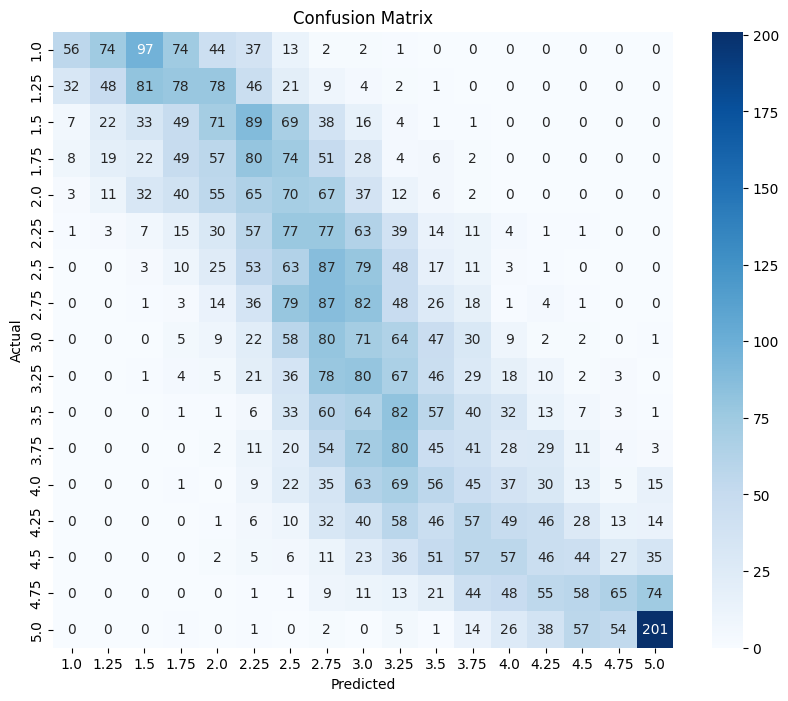

Accuracy: 0.1584
None


In [14]:
modelCNN = CNN().to(device)
optimizer = optim.Adagrad(modelCNN.parameters(), lr=0.001, weight_decay=0.0001)
#optimizer = optim.Adadelta(modelCNN.parameters(), lr=0.001, weight_decay=0.0001)
#lr = 0.001
train_model(modelCNN, optimizer, num_epochs=50)

Mean Squared Error: 0.6203 and Mean Absolute Error: 0.6315


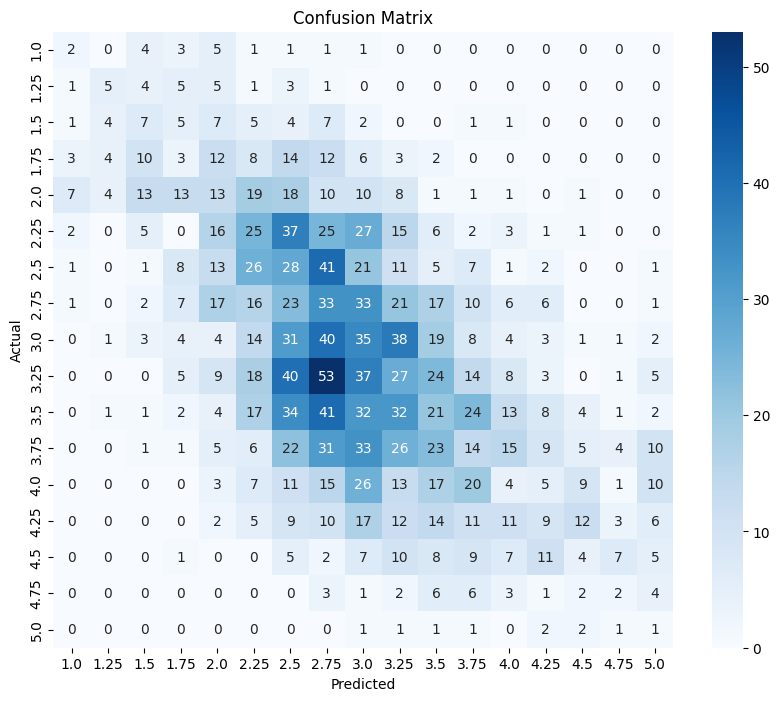

Accuracy: 0.1121


In [15]:
evaluate_model(modelCNN, test_loader, conf=True)